In [2]:
from importlib import reload
import pandas  as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
import os
from sklearn.metrics import mutual_info_score, normalized_mutual_info_score, adjusted_mutual_info_score
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVR
from tqdm.notebook import tqdm

## Loading git data

In [3]:
path = 'data/full_pkls/'
files = os.listdir(path)
len(files), files

(14,
 ['mongodb____mongo.pkl',
  'apache____airflow.pkl',
  'deepfakes____faceswap.pkl',
  'numpy____numpy.pkl',
  'ray-project____ray.pkl',
  'godotengine____godot.pkl',
  'apache____superset.pkl',
  'tensorflow____tensorboard.pkl',
  'ipython____ipython.pkl',
  'x64dbg____x64dbg.pkl',
  '3b1b____manim.pkl',
  'pandas-dev____pandas.pkl',
  'bokeh____bokeh.pkl',
  'apache____spark.pkl'])

In [117]:
file = 'mongodb____mongo.pkl'
print(file)
data = pickle.load(open(path + file, 'rb'))

mongodb____mongo.pkl


### making signal for metrics

In [118]:
def issues_state_processing(states, timings, lifetimes):
    start_days = np.array([t//(24*3600) for t in timings])
    end_days = (start_days + lifetimes)*(1-states)
    m = min(end_days[end_days > 0].tolist() + start_days.tolist())
    M = max(end_days[end_days > 0].tolist() + start_days.tolist())
    sig = np.zeros(M-m+1)
    for d in end_days:
        if d > 0:
            sig[d-m] += 1
    return sig, M, m


def prepare_signals(data):
    ## closed issues
    closed_issues, max_issue_time, min_issue_time = issues_state_processing(
        states=data['issues_state'], timings=data['opened_issues'], lifetimes=data['issues_lifetime']
    )
    ## stars, forks, opened_issues, closed_issues
    signals = {}
    for k in ['forks', 'stars', 'opened_issues']:
        metric, a, b = get_single_signal(data[k], time_scale=24*3600, binarize=False)
        signals[k] = {
            'sig': metric,
            'm' : b,
            'M' : a
        }
    signals['closed_issues'] = {
        'sig' : closed_issues,
        'm' : min_issue_time,
        'M' : max_issue_time    
    }

    min_act_time = min([min(v) for v in data['activities'].values()]) // (24*3600)
    max_act_time = max([max(v) for v in data['activities'].values()]) // (24*3600)
    m = min([v['m'] for v in signals.values()] + [min_act_time])
    M = max([v['M'] for v in signals.values()] + [max_act_time])

    for k in signals:
        signals[k] = np.pad(signals[k]['sig'], pad_width=(signals[k]['m'] - m, M - signals[k]['M']))
    
    sig = get_signal(data['activities'], time_scale=24*3600, binarize=True)
    signals['activities'] = np.pad(sig, pad_width=(min_act_time - m, M - max_act_time))
    return signals

In [119]:
signals = prepare_signals(data)
for k in signals:
    print(k, signals[k].shape)

forks (5005,)
stars (5005,)
opened_issues (5005,)
closed_issues (5005,)
activities (484, 5005)


## temporal phi

In [120]:
import social_phi
from social_phi import experiment_hop_range

## loading phi stats
csv_path = 'data/phi_stats/' + file[:-4] + '.csv'
if os.path.exists(csv_path):
    stats = pd.read_csv(csv_path)
else:
    stats = experiment_hop_range(sig=signals['activities'], window=30, min_hop=1, max_hop=30, silent=False)
    stats.to_csv(csv_path, index=False)

In [121]:
from social_phi import phi_for_act_sig

## calculating phi for specific tau
tau = int(stats.hop.values[np.argmax(stats.linear_avg_phi.values)])
print(tau)
phis, n_users = phi_for_act_sig(signals['activities'], window=30, hop=tau, nan_policy='linear', base=2)
print(phis.shape)

23


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/social_phi/phi.py:13: RuntimeWarning: invalid value encountered in double_scalars
  prod = lambda x: x[0]*x[1]
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/social_phi/phi.py:23: RuntimeWarning: divide by zero encountered in log
  term2 = 0.5*np.sum([np.log(s_m1) - np.log(s_part_m1_m2) for s_m1, s_part_m1_m2 in zip(S_M1, S_part_M1_M2)])
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/social_phi/phi.py:23: RuntimeWarning: invalid value encountered in double_scalars
  term2 = 0.5*np.sum([np.log(s_m1) - np.log(s_part_m1_m2) for s_m1, s_part_m1_m2 in zip(S_M1, S_part_M1_M2)])
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/numpy/core/fromnumeric.py:87: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)



(216,)


In [122]:
metrics = {}
for k in signals:
    if k != 'activities':
        metrics[k] = sliding_window(signals[k].reshape(1,-1), agg_func=np.sum, window=30, hop=tau)[0]
metrics['num_activities'] = sliding_window(signals['activities'].sum(axis=0).reshape(1,-1), agg_func=np.sum, window=30, hop=tau)[0]
metrics['num_active_users'] = n_users

In [129]:
## put everythin in a data frame
df = pd.DataFrame(columns=[
    'phi', 'num_activities', 'num_active_users', 'forks', 'stars', 'opened_issues', 'closed_issues'
])
df['phi'] = phis
for k in metrics:
    df[k] = metrics[k]

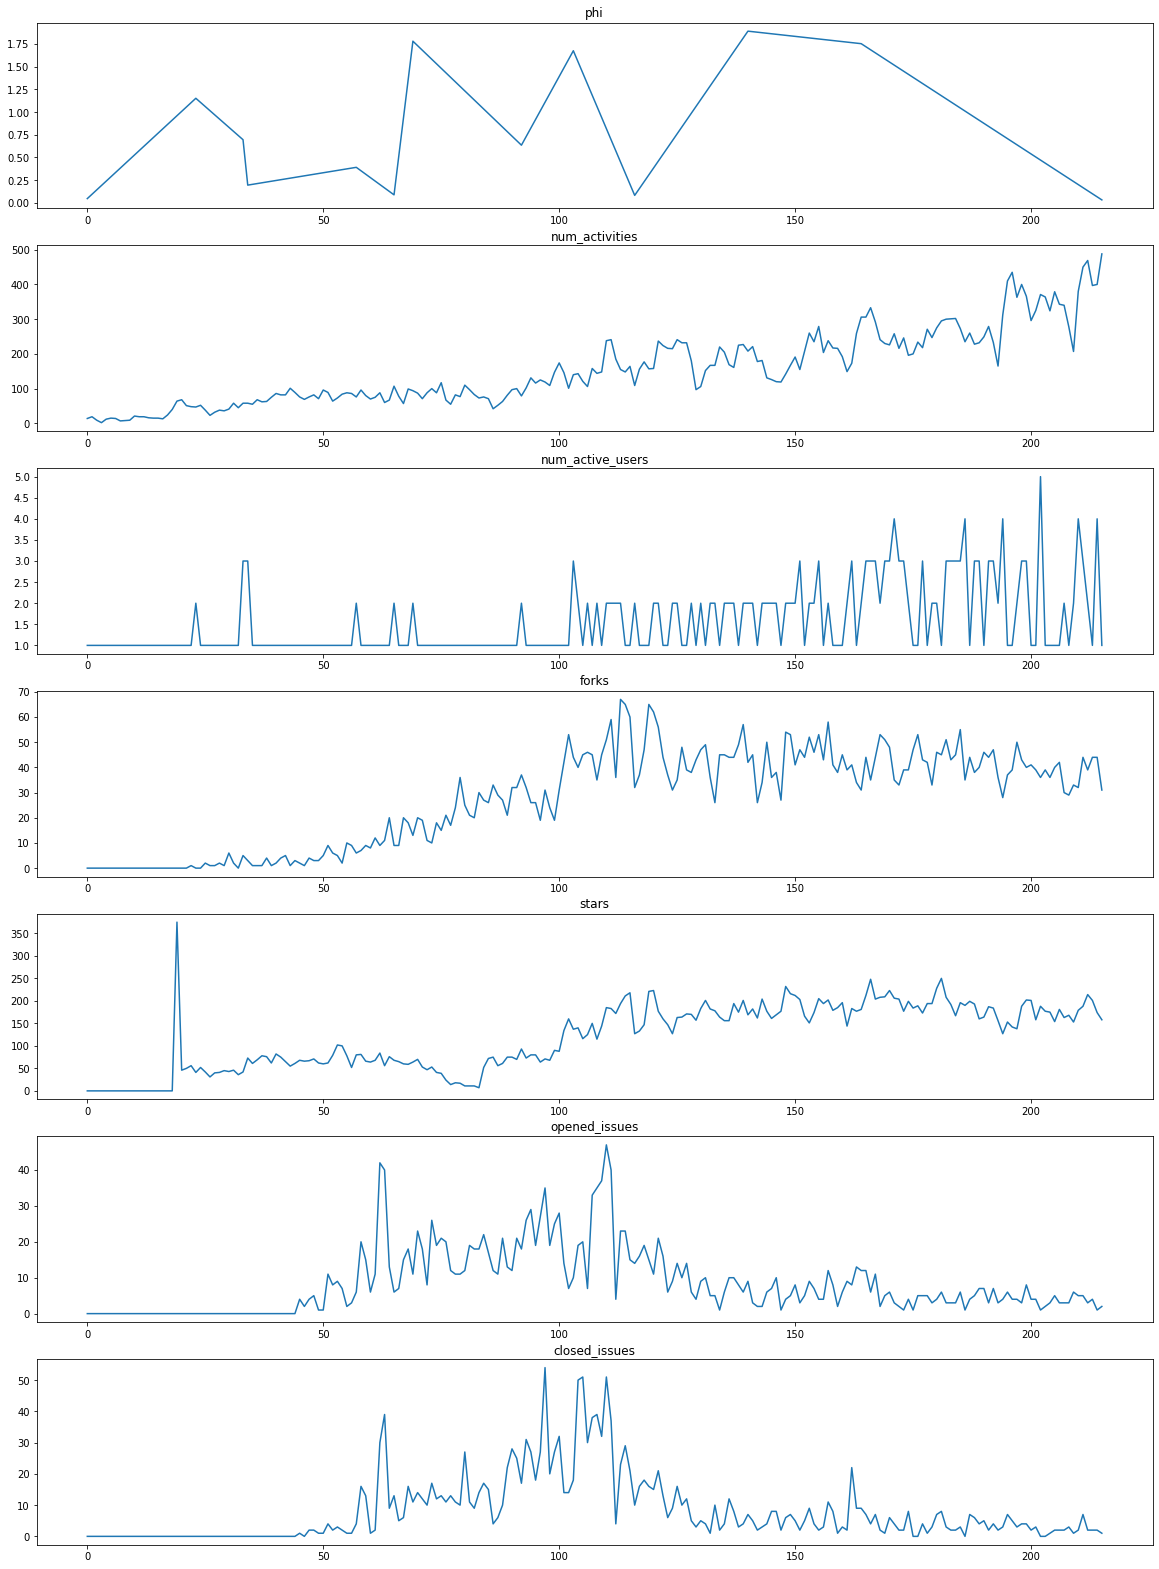

In [130]:
plt.figure(figsize=(20,4*df.shape[1]))
for i,col in enumerate(df.columns):
    plt.subplot(df.shape[1], 1, i+1)
    plt.title(col)
    plt.plot(df[col])
plt.show()

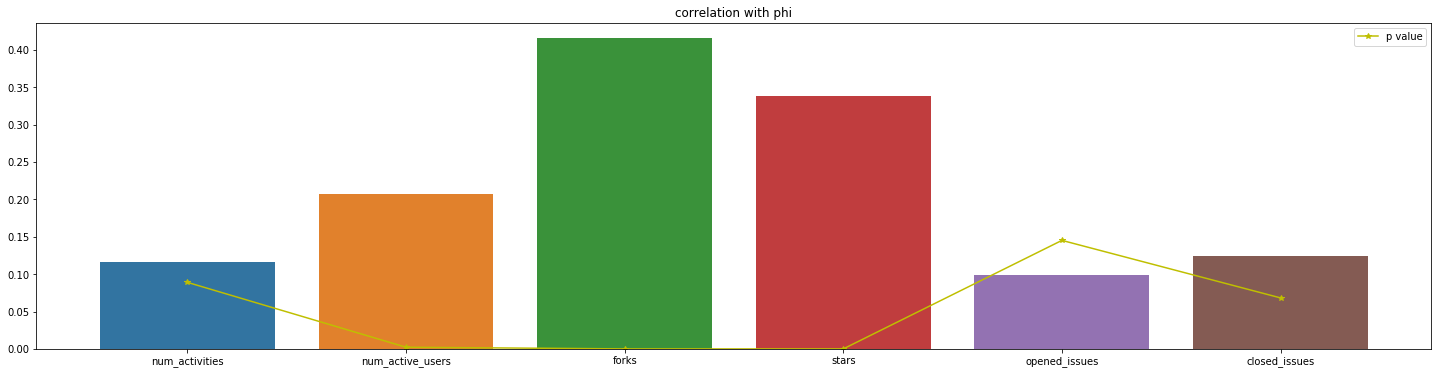

In [131]:
from scipy import stats as sci_stats
from sklearn.metrics import mutual_info_score, normalized_mutual_info_score, adjusted_mutual_info_score


corrs = df.corr(method='pearson') # spearman , kendall
corr_tvals = corrs * np.sqrt(df.shape[0] - 2) / np.sqrt(1 - corrs**2)
corr_pvals = sci_stats.t.sf(np.abs(corr_tvals), df.shape[0] - 2)*2
corr_pvals = pd.DataFrame(corr_pvals, columns=df.columns, index=df.columns)

plt.figure(figsize=(25,6))
plt.title('correlation with phi')
sns.barplot(y=corrs.drop(['phi'], axis=1).loc['phi'], x=df.drop(['phi'], axis=1).columns)
plt.plot(corr_pvals.drop(['phi'], axis=1).loc['phi'], label='p value', marker='*', c='y')
plt.ylabel('')
plt.legend()
plt.show()

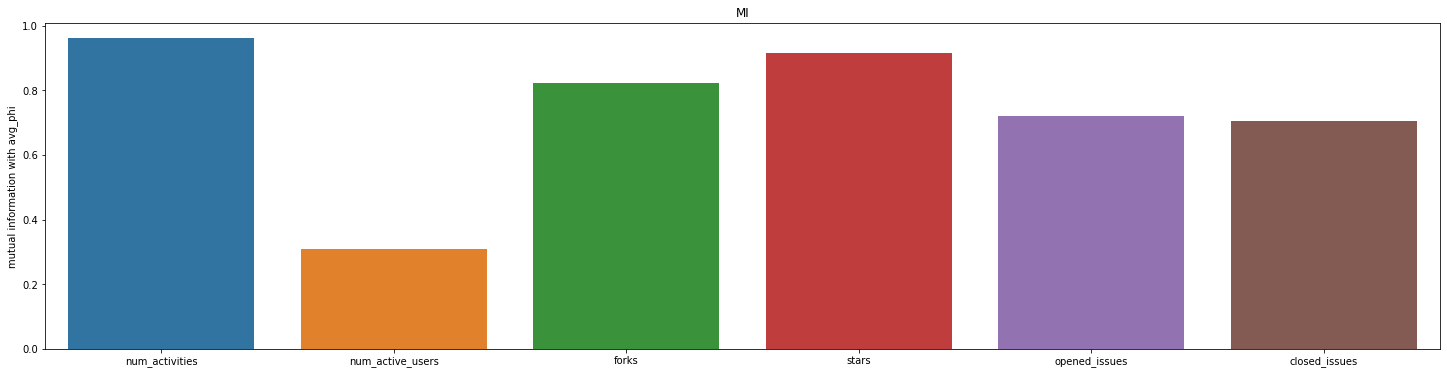

In [132]:
mis = np.zeros(shape=df.shape[1]-1)
for i,col in enumerate(df.drop(['phi'], axis=1).columns):
    mis[i] = normalized_mutual_info_score(df.phi, df[col])

plt.figure(figsize=(25,6))
plt.title('MI')
sns.barplot(y=mis, x=df.drop(['phi'], axis=1).columns)
plt.ylabel('mutual information with avg_phi')
plt.show()

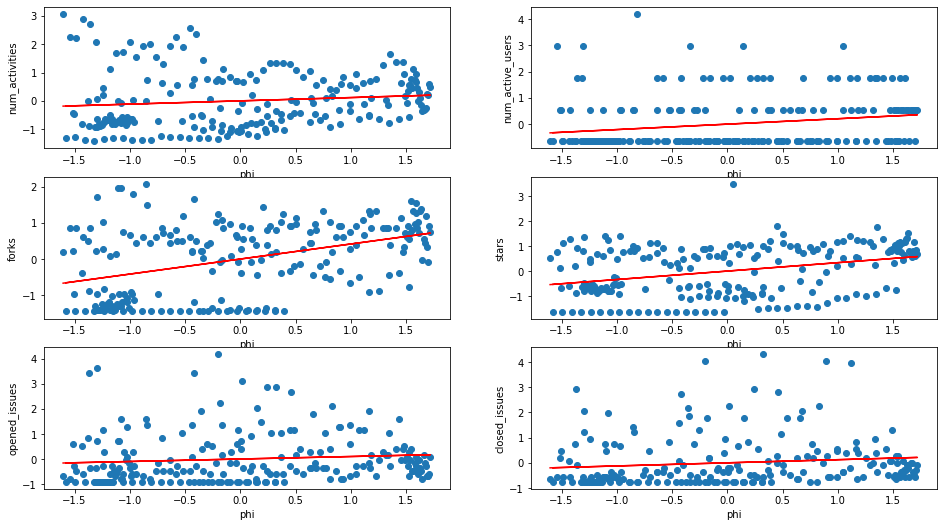

In [133]:
n = len(df.columns) - 1
standardize = lambda v : (v - v.mean()) / v.std()
x = standardize(df['phi'].values)

plt.figure(figsize=(16,n*2))
for i,col in enumerate(df.drop(['phi'], axis=1).columns):
    y = standardize(df[col].values)
    lr = LinearRegression().fit(x.reshape(-1,1),y)
    
    plt.subplot(n // 2 + 1, 2, i+1)
    plt.xlabel('phi')
    plt.ylabel(col)
    plt.scatter(x=x, y=y)
    plt.plot(x, lr.predict(x.reshape(-1,1)), c='r')
    
plt.show()

num_activities pvalue=2.0235453572057427e-09 lr=35.95
num_active_users pvalue=1.0 lr=-0.40
forks pvalue=0.024123499846179036 lr=5.09
stars pvalue=0.007553112867728825 lr=7.14
opened_issues pvalue=0.022431890346601497 lr=5.21
closed_issues pvalue=0.01050585124586775 lr=6.55


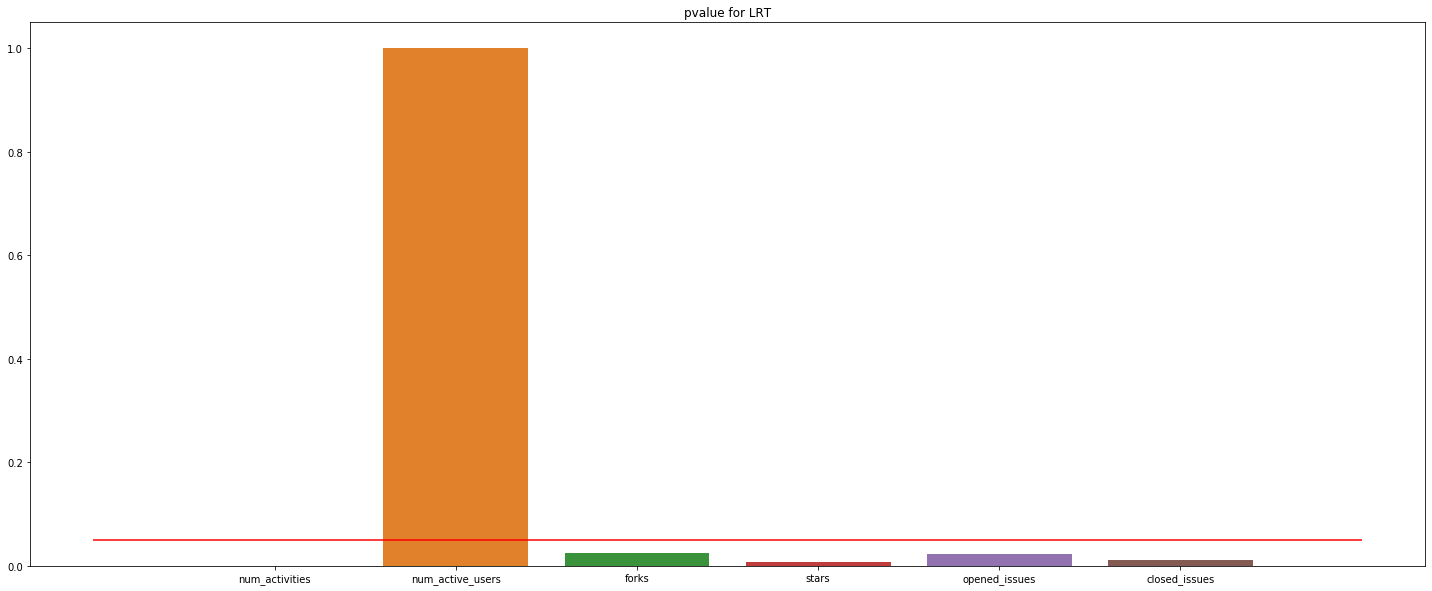

In [139]:
from scipy.stats.distributions import chi2

def experiment_regression(data, keys : list, plot=True):
    scale = StandardScaler()
    X_res = data.drop(['phi'] + keys, axis=1).values
    X = data.drop(['phi'], axis=1).values
    X = scale.fit_transform(X)
    X_res = scale.fit_transform(X_res)
    standardize = lambda x: (x-x.mean())/x.std()
    y = standardize(data['phi'].values)

    
    lr = SVR()
    lr.fit(X, y)
    pred = lr.predict(X)
    
    lr_res = SVR()
    lr_res.fit(X_res, y)
    pred_res = lr_res.predict(X_res)

    err = np.sum(np.square(y - pred))
    err_res = np.sum(np.square(y - pred_res))
    LR = err_res - err
    pvalue = chi2.sf(LR, 1)

    if plot:
        plt.figure(figsize=(20,10))
        plt.subplot(2,1,1)
        plt.title('full model')
        plt.plot(y)
        plt.plot(pred)

        plt.subplot(2,1,2)
        plt.title('restricted model')
        plt.plot(y)
        plt.plot(pred_res)
        plt.show()
    return LR, pvalue

pvalues = []
for col in df.drop(['phi'], axis=1).columns:
    lr, p = experiment_regression(df, keys=[col], plot=False)
    pvalues += [p]
    print(col, f"pvalue={p}", 'lr={:.2f}'.format(lr))

plt.figure(figsize=(25,10))
plt.title('pvalue for LRT')
sns.barplot(x=df.drop(['phi'], axis=1).columns, y=pvalues)
plt.hlines(y=0.05, xmin=-1, xmax=6, colors='r')
plt.show()